# Improving Employee Retention 
## Insight data challenge 
## Mihye Choi 
## October, 2020


# Executive Summary

## The goal here is to predict when employees are going to quit by understanding the main drivers of employee churn.

### Based on historical data from employees who have left companies, the following actions may help improve employee retention:

1. Salary has a small positive effect on retention. So if budget permits, it would be optimal to pay more.
2. The most likely time for an employee to turnover occurs between 250 days and 500 days, just around 1 year of tenure. There could be a variety of reasons behind this, from pressure of ramping up, to perverse incentive like vesting schedules. It would be worthwhile to dive deeper into this topic.
3. Entry level employees are less likely to turnover. Mid level employees with 5-15 years of experience at significantly more likely. There is likely more opportunity in the job market for these employees so the company need to focus on the mid-levels for retention improvement efforts
4. Customer service agents are both far more likely to turnover and have more in absolutely turnovers. This is a significant drain on company resources and HR must leverage salary or other quality of life tools to improve retention.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import statsmodels.api as sm
import datetime

## Data Overview and Cleaning:

Below is a sample of the data showing the available features including employee ID, company ID, department, seniority, salary, work start date (join_date), and quit date (if the employee is still working for the company, value in quit_date is missing (NaN).

Inital descriptive statistics and exploratory data analysis showed (1) several data have more than 70 years of seniority and (2) different format in 'date' data. Because (1) data with > 70 year seniority are likely entry errors, and (2) the date is from '2011-01-24' (start-date) to '2015-12-13' (end-date), data ranged beyond (!) and (2) were removed. There were no other obvious outlier values in the other continuous variables.

Additionally I created two new culumns (1) 'turnover' and (2) 'days at company' for the final model creation.

In [31]:
df = pd.read_csv('employee_retention.txt', delimiter=',')
df= df.drop(df.columns[[0]], axis=1)
df.sample(5)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
11352,1007548.0,6,temp_contractor,0,6454.0,2010-01-10,2010-04-10
5867,662020.0,1,engineer,1,81000.0,01.30.2012,2013-03-22
4678,999668.0,6,customer_service,23,NaN,09.29.2014,2015-10-02
15093,1009713.0,8,temp_contractor,0,6830.0,2008-07-11,2008-10-09
23143,788617.0,3,engineer,8,135000.0,2014-08-04,NaN


In [32]:
# Data pre-processing and cleaning 
dept_check = df.dept.value_counts()/len(df) # typo check 
print(dept_check)

df = df[df.seniority < 70] # seniority value check, value over 70 is likely to be an error
df['join_date'] = pd.to_datetime(df.join_date) # to have the consistent date format, print(df.join_date.min())
df['quit_date'] = pd.to_datetime(df.quit_date) # print(df.quit_date.max())
start_date = '2011-01-24'# set the right range 
end_date = '2015-12-13'# set the right range 
mask = (df['join_date'] > start_date) & (df['join_date'] <= end_date)
df = df.loc[mask]
df.sample(10)

temp_contractor     0.288168
customer_service    0.264538
engineer            0.132932
data_science        0.091926
sales               0.091407
marketing           0.091263
design              0.039767
Name: dept, dtype: float64


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
25335,809207.0,1,customer_service,24,128000.0,2012-06-11,2013-06-21
11283,111131.0,6,customer_service,2,24000.0,2013-08-12,2014-07-07
18579,296491.0,1,engineer,6,198000.0,2011-11-07,2012-10-26
6043,184644.0,1,customer_service,4,29000.0,2014-08-18,NaT
24026,741116.0,4,customer_service,11,61000.0,2013-09-09,NaT
17938,473656.0,10,sales,6,98000.0,2015-06-15,NaT
18472,722043.0,2,engineer,22,269000.0,2011-07-05,2013-07-26
32786,157722.0,5,customer_service,23,94000.0,2015-06-01,NaT
4699,386651.0,1,customer_service,4,27000.0,2015-09-28,NaT
29223,350583.0,1,engineer,14,245000.0,2013-04-08,NaT


In [33]:
# make new columns, (1) days_at_company for calculating retention days (2) turnover (quit =1).  
df['quit_date2'] = df['quit_date'].fillna('2015-12-13')
df['quit_date2']=  pd.to_datetime(df.quit_date2)
df['days_at_company'] = df['quit_date2']-df['join_date']
df['days_at_company'] = df['days_at_company'].dt.days

df['quit'] = df['quit_date'].fillna(0) 
df.quit[df.quit != 0] = 1
df.sample(10)

<ipython-input-33-08fc848fb521>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.quit[df.quit != 0] = 1


,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit_date2,days_at_company,quit
28597,132988.0,2,engineer,17,315000.0,2015-11-18,NaT,2015-12-13,25,0
14890,398384.0,1,data_science,25,290000.0,2012-10-22,2015-05-29,2015-05-29,949,1
31833,783004.0,2,engineer,22,291000.0,2014-05-27,NaT,2015-12-13,565,0
4001,186753.0,7,customer_service,18,109000.0,2012-06-14,2013-07-19,2013-07-19,400,1
15284,949940.0,5,customer_service,25,94000.0,2012-12-31,2013-12-27,2013-12-27,361,1
7878,848016.0,7,engineer,24,243000.0,2014-02-24,NaT,2015-12-13,657,0
20354,711557.0,2,sales,1,47000.0,2012-06-11,2014-08-29,2014-08-29,809,1
34299,962293.0,1,customer_service,6,71000.0,2012-10-01,NaT,2015-12-13,1168,0
25161,930099.0,1,customer_service,13,92000.0,2013-01-23,2014-01-31,2014-01-31,373,1
22863,21919.0,6,sales,14,103000.0,2015-06-08,NaT,2015-12-13,188,0


# Exploratory Data Analysis (EDA)

         employee_id    company_id     seniority         salary  \
count   24619.000000  24619.000000  24619.000000   24380.000000   
mean   501670.191153      3.427556     14.118526  138160.746514   
std    288930.746415      2.700800      8.055201   76045.876338   
min        36.000000      1.000000      1.000000   17000.000000   
25%    250469.500000      1.000000      7.000000   79000.000000   
50%    500786.000000      2.000000     14.000000  123000.000000   
75%    753147.000000      5.000000     21.000000  187000.000000   
max    999969.000000     12.000000     29.000000  408000.000000   

       days_at_company  
count     24619.000000  
mean        573.721435  
std         361.316221  
min           3.000000  
25%         333.000000  
50%         424.000000  
75%         781.000000  
max        1777.000000  


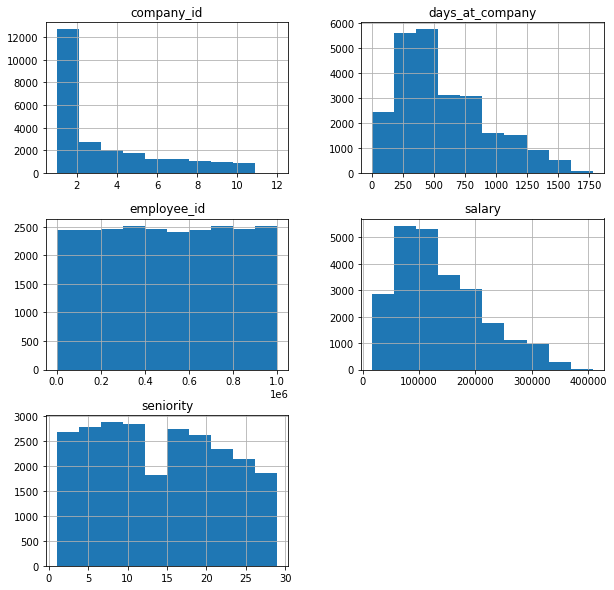

In [28]:
print(pd.DataFrame.describe(df))
df.hist(figsize=(10,10))
plt.show()

In [6]:
# the outputs show how each factor impacts the likelihood of the turnover rate.
print(len(df.quit))
print(df.groupby(df.quit).mean())
print(df.quit.value_counts()/len(df))

24619
        employee_id  company_id  seniority         salary  days_at_company
quit                                                                      
0     501079.237759    3.387688  14.123392  141192.259112       527.039224
1     502162.777016    3.460788  14.114471  135633.574007       612.633127
1    0.545392
0    0.454608
Name: quit, dtype: float64


company_id    1     2     3     4    5    6    7    8    9    10  11  12
quit                                                                    
0           3865  2016  1218   909  772  579  532  468  432  385   4  12
1           4595  2189  1522  1141  978  709  691  573  526  479  12  12


Text(0.5, 0, 'Company ID')

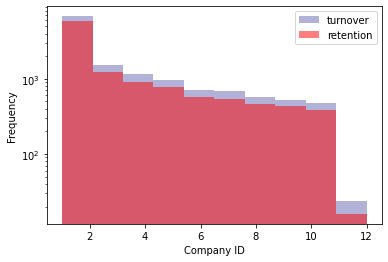

In [7]:
# turnover frequency by companies
print(pd.crosstab(df.quit, df.company_id)) 
df[df.quit==1].company_id.plot(kind='hist', logy=True, alpha=0.3, label= 'turnover', color = "navy")
df[df.quit==0].company_id.plot(kind='hist', logy=True, alpha=0.5, label= 'retention', color = "red")
plt.legend(loc=1, fontsize='medium')
plt.xlabel('Company ID')


dept  customer_service  data_science  design  engineer  marketing  sales
quit                                                                    
0                 4086          1508     602      2251       1384   1361
1                 5061          1664     773      2348       1778   1803


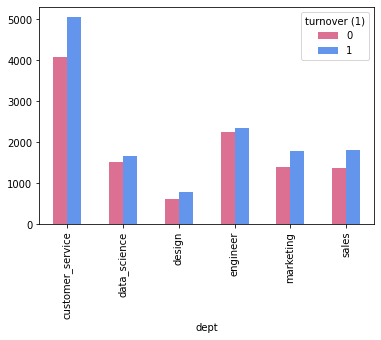

In [40]:
# turnover frequency by department. Customer Service dept has the most turnover
print(pd.crosstab(df.quit, df.dept)) 
pd.crosstab(df.dept,df.quit).plot(kind='bar', color=['palevioletred','cornflowerblue'])
plt.legend(title='turnover (1)')

days_at_company  3     4     5     6     10    11    12    13    18    19    \
quit                                                                          
0                   2     4     5    78     4     3    10    86    13     7   
1                   0     0     0     0     0     0     0     0     0     0   

days_at_company  ...  1707  1714  1721  1726  1728  1742  1763  1769  1770  \
quit             ...                                                         
0                ...     1     1     1     0     2     1     1     1     2   
1                ...     0     0     0     1     0     0     0     0     0   

days_at_company  1777  
quit                   
0                   3  
1                   0  

[2 rows x 1352 columns]


Text(0.5, 0, 'days')

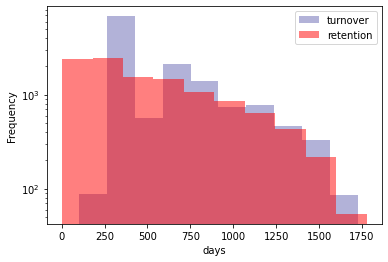

In [481]:
# turnover frequency by days at company. There is a peak (250-500 days) where turnover is highest. 
print(pd.crosstab(df.quit, df.days_at_company)) 
df[df.quit==1].days_at_company.plot(kind='hist', logy=True, alpha=0.3, label= 'turnover', color = "navy")
df[df.quit==0].days_at_company.plot(kind='hist', logy=True, alpha=0.5, label= 'retention', color = "red")
plt.legend(loc=1, fontsize='medium')
plt.xlabel('days')

seniority   1    2    3    4    5    6    7    8    9    10  ...   20   21  \
quit                                                         ...             
0          431  442  434  473  403  379  417  422  422  404  ...  375  327   
1          426  496  446  421  529  571  510  582  519  521  ...  467  452   

seniority   22   23   24   25   26   27   28   29  
quit                                               
0          359  355  345  312  335  300  265  318  
1          403  428  394  399  357  342  318  306  

[2 rows x 29 columns]


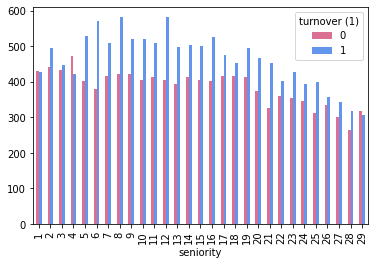

In [41]:
# turnover frequency by years of seniority
print(pd.crosstab(df.quit, df.seniority)) 
pd.crosstab(df.seniority,df.quit).plot(kind='bar', color=['palevioletred','cornflowerblue'])
plt.legend(title='turnover (1)')

Text(0.5, 0, 'Salary')

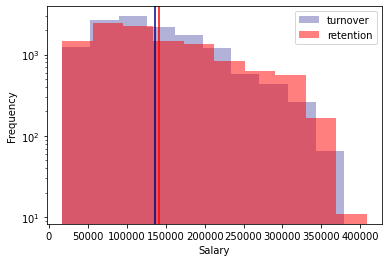

In [483]:
# turnover frequency by salary. 
df[df.quit==1].salary.plot(kind='hist', logy=True, alpha=0.3, label= 'turnover', color = "navy")
df[df.quit==0].salary.plot(kind='hist', logy=True, alpha=0.5, label= 'retention', color = "red")
plt.axvline(df[df.quit==1].salary.mean(), color = 'navy', label = '')
plt.axvline(df[df.quit==0].salary.mean(), color = 'red', label = '')
plt.legend(loc=1, fontsize='medium')
plt.xlabel('Salary')

## Take Away from the EDA:
Employees who turnovered, on average:

    (1) work in customer service deaprtment
    (2) left companies when they just around 1 year of tenure (250 - 500 days)
    (3) mid-senior level (5-15 years of seniority) 

Thus, I anticipate that department, seniority, days at company will be important feautures for prediction.

# Turnover Model

I comapred a logistic regression vs. survival analysis to predict customer conversion. This is simple base model to start with that provides interpretability, which can be used to make informed marketing recommendation. In addition, the features are not correlated so a logistic regression should peform well. 

This dataset is imbalanced so I am going to downsample the majority class (not converted customers) in my training data set before model training. Downsampling will decrease the size of the dataset so to ensure that the balancing provides increased model performance I will compare a logistic regression with and without a balanced training test. The test set will remain imbalanced to as to be more realistic.

A random forest is another possibilty and would not require balancing the data set, however the feature importances are not as immediately interpretible as the logistic regression.

In [534]:
cat_vars=['company_id','dept']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    df1=df.join(cat_list)
    final=df1
print(final)
final.dropna()
#final = df[['company_id','dept','seniority','salary','quit']]
#final = pd.get_dummies(data=final, columns=['company_id', 'dept'])
#print(final)

       employee_id  company_id              dept  seniority    salary  \
1         388804.0           8            design         21  191000.0   
2         407990.0           3            design          9   90000.0   
3         120657.0           2          engineer         20  298000.0   
5         287530.0           5         marketing         20  180000.0   
6         561043.0           3  customer_service         18  119000.0   
...            ...         ...               ...        ...       ...   
34695     414232.0           6            design         22  150000.0   
34696     702053.0           2            design         23  192000.0   
34697     998574.0           5         marketing          6  106000.0   
34698      90987.0           3  customer_service          2   24000.0   
34701     963023.0           2            design          2   53000.0   

       join_date  quit_date  quit quit_date2  days_at_company  \
1     2011-05-17 2012-03-16     1 2012-03-16              

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,quit,quit_date2,days_at_company,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
1,388804.0,8,design,21,191000.0,2011-05-17,2012-03-16,1,2012-03-16,304,0,0,1,0,0,0
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10,1,2015-04-10,1110,0,0,1,0,0,0
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30,1,2015-01-30,662,0,0,0,1,0,0
6,561043.0,3,customer_service,18,119000.0,2012-07-02,2014-03-28,1,2014-03-28,634,1,0,0,0,0,0
7,702479.0,7,data_science,7,140000.0,2011-12-27,2013-08-30,1,2013-08-30,612,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34693,759749.0,1,design,19,199000.0,2014-02-24,2015-03-06,1,2015-03-06,375,0,0,1,0,0,0
34695,414232.0,6,design,22,150000.0,2014-09-29,2015-10-30,1,2015-10-30,396,0,0,1,0,0,0
34697,998574.0,5,marketing,6,106000.0,2013-09-23,2015-07-31,1,2015-07-31,676,0,0,0,0,1,0
34698,90987.0,3,customer_service,2,24000.0,2011-06-06,2013-07-11,1,2013-07-11,766,1,0,0,0,0,0


In [535]:
final.drop(df.columns[[0,1,2,4,5,6,8]], axis=1, inplace=True)
final.columns.values
final_vars=final.columns.values.tolist()
y=['quit']
X=[i for i in final_vars if i not in y]
print(final)

X=final[X]
y=final[y]

       seniority  quit  days_at_company  dept_customer_service  \
1             21     1              304                      0   
2              9     1             1110                      0   
3             20     1              662                      0   
5             20     0              531                      0   
6             18     1              634                      1   
...          ...   ...              ...                    ...   
34695         22     1              396                      0   
34696         23     0              167                      0   
34697          6     1              676                      0   
34698          2     1              766                      1   
34701          2     1              710                      0   

       dept_data_science  dept_design  dept_engineer  dept_marketing  \
1                      0            1              0               0   
2                      0            1              0           

In [536]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [537]:
from sklearn.metrics import accuracy_score
print('Logistic regression accuracy: {:.3f}'.format(accuracy_score(y_test, logreg.predict(X_test))))

Logistic regression accuracy: 0.639


In [538]:
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.680746
         Iterations 4
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.013     
Dependent Variable:   quit              AIC:               23478.5973
Date:                 2020-07-13 00:14  BIC:               23540.6340
No. Observations:     17233             Log-Likelihood:    -11731.   
Df Model:             7                 LL-Null:           -11883.   
Df Residuals:         17225             LLR p-value:       1.5868e-61
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       4.0000                                         
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
seniority             -0.0006   0.0019 -0.3252 0.7450 -0.0044  0.0031
days_at_company 